# Prediction of the number of bicycle passing between 00:01 AM and 09:00 AM on Friday, April 2nd



## The required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import math
import itertools
import warnings
from statsmodels import api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

## The dataset

In [9]:
data = pd.read_csv("data_bike.csv")

In [3]:
data_clean = data.copy()
data_clean = data_clean.drop([0, 8], axis = 0)
data_clean = data_clean.drop(columns = ['Vélos depuis le 1er janvier / Grand total', 'Unnamed: 4', 'Remarque'])
data_clean = data_clean.dropna(how = 'any')
data_clean = data_clean.rename(columns = {"Vélos ce jour / Today's total": 'Bicycle'})
data_clean['Bicycle'] = data_clean['Bicycle'].astype(int)


,Date,Heure / Time,Bicycle
3,12/03/2020,11:05:00,109
4,12/03/2020,14:30:00,441
5,13/03/2020,10:02:00,385
6,13/03/2020,14:15:00,769
7,13/03/2020,18:21:00,1286
...,...,...,...
1446,24/03/2021,14:46:00,1002
1447,24/03/2021,18:31:00,1610
1448,24/03/2021,19:05:00,1703
1449,25/03/2021,08:28:00,231


In [4]:
data_clean['Date'] = data_clean['Date'] + " " + data_clean['Heure / Time']
data_clean = data_clean.set_index('Date')
data_clean = data_clean.drop('Heure / Time', 1)
data_clean.index = pd.to_datetime(data_clean.index,format="%d/%m/%Y %H:%M:%S")
data_clean = data_clean.sort_index()
data_clean.head(20)

,Bicycle
Date,
2020-03-12 11:05:00,109
2020-03-12 14:30:00,441
2020-03-13 10:02:00,385
2020-03-13 14:15:00,769
2020-03-13 18:21:00,1286
2020-03-14 16:26:43,642
2020-03-15 09:05:50,50
2020-03-15 09:53:00,70
2020-03-15 11:25:00,125


In [5]:
serie_bike = data_clean.copy()
serie_bike = serie_bike[(serie_bike.index.time >= pd.to_datetime("00:01:00").time()) &
                 (serie_bike.index.time <= pd.to_datetime("09:01:00").time())]
serie_bike = serie_bike.loc['2021-01-16':'2021-03-25']
serie_bike

,Bicycle
Date,
2021-01-17 07:01:00,15
2021-01-18 08:29:00,188
2021-01-21 08:32:00,186
2021-01-22 08:37:00,182
2021-01-24 07:38:00,6
2021-01-25 08:32:00,189
2021-01-26 08:30:00,182
2021-01-28 08:08:00,99
2021-01-28 08:32:00,178


## Handling missing data

In [6]:
data_week = data_clean.copy()
data_week = data_week[(data_week.index.time >= pd.to_datetime("00:01:00").time()) &
                 (data_week.index.time <= pd.to_datetime("09:15:00").time())]
data_week = data_week.loc['2021-01-16':'2021-03-25']
data_week['Weekday'] = pd.to_datetime(data_week.index)
data_week['Weekday'] = data_week['Weekday'].dt.day_name()
data_week['Weekday'] = data_week['Weekday'].apply(str)
data_week = data_week.query(' Weekday == ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]')
data_week = data_week.drop([data_week.index[5], data_week.index[13],data_week.index[14],data_week.index[17],data_week.index[22],data_week.index[23],data_week.index[24],data_week.index[25],data_week.index[27]])
print('mean week', data_week.mean().apply(np.floor), 'median week', data_week.median().apply(np.floor), data_week)

mean week Bicycle    182.0
dtype: float64 median week Bicycle    182.0
dtype: float64                      Bicycle    Weekday
Date                                   
2021-01-18 08:29:00      188     Monday
2021-01-21 08:32:00      186   Thursday
2021-01-22 08:37:00      182     Friday
2021-01-25 08:32:00      189     Monday
2021-01-26 08:30:00      182    Tuesday
2021-01-28 08:32:00      178   Thursday
2021-01-29 07:35:00       35     Friday
2021-02-04 08:29:00      183   Thursday
2021-02-05 08:29:00      151     Friday
2021-02-08 08:30:00      170     Monday
2021-02-12 08:28:00      140     Friday
2021-02-16 08:16:00       67    Tuesday
2021-02-19 09:00:00      186     Friday
2021-03-04 08:25:00      187   Thursday
2021-03-10 09:01:00      322  Wednesday
2021-03-12 08:27:00      175     Friday
2021-03-19 08:26:00      217     Friday
2021-03-23 08:29:00      271    Tuesday
2021-03-24 08:00:00      127  Wednesday
2021-03-25 08:50:00      318   Thursday


In [7]:
data_week_end = data_clean.copy()
data_week_end = data_week_end[(data_week_end.index.time >= pd.to_datetime("00:01:00").time()) &
                 (data_week_end.index.time <= pd.to_datetime("10:00:00").time())]
data_week_end = data_week_end.loc['2021-01-16':'2021-03-25']
data_week_end['Weekday'] = pd.to_datetime(data_week_end.index)
data_week_end['Weekday'] = data_week_end['Weekday'].dt.day_name()
data_week_end['Weekday'] = data_week_end['Weekday'].apply(str)
data_week_end = data_week_end.query(' Weekday == ["Saturday", "Sunday"]')
data_week_end = data_week_end.drop([data_week_end.index[2], data_week_end.index[6]])
print('mean week-end', data_week_end.mean(), data_week_end)

mean week-end Bicycle    55.714286
dtype: float64                      Bicycle   Weekday
Date                                  
2021-01-16 09:48:00       70  Saturday
2021-01-17 07:01:00       15    Sunday
2021-01-24 07:38:00        6    Sunday
2021-02-06 09:44:00       78  Saturday
2021-02-27 06:23:00       15  Saturday
2021-03-06 09:24:00       96  Saturday
2021-03-20 09:48:00      110  Saturday


In [8]:
serie_bike = serie_bike.drop([serie_bike.index[7],serie_bike.index[15], serie_bike.index[16], serie_bike.index[20], serie_bike.index[25], serie_bike.index[26], serie_bike.index[27], serie_bike.index[28], serie_bike.index[30]])
serie_bike = serie_bike.resample("1D").sum() #1D for 1 day : day per day
serie_bike['Weekday'] = pd.to_datetime(serie_bike.index)
serie_bike['Weekday'] = serie_bike['Weekday'].dt.day_name()
serie_bike['Weekday'] = serie_bike['Weekday'].apply(str)
serie_bike.head(50)

,Bicycle,Weekday
Date,,
2021-01-17,15,Sunday
2021-01-18,188,Monday
2021-01-19,0,Tuesday
2021-01-20,0,Wednesday
2021-01-21,186,Thursday
2021-01-22,182,Friday
2021-01-23,0,Saturday
2021-01-24,6,Sunday
2021-01-25,189,Monday


In [9]:
for i in range(0,len(serie_bike)):
    if serie_bike.iat[i,0]==0 and (serie_bike.iat[i,1]=="Saturday" or serie_bike.iat[i,1]=="Sunday"):
        serie_bike.loc[serie_bike.index[i],'Bicycle'] = 55
    elif serie_bike.iat[i,0]==0 and (serie_bike.iat[i,1]!="Saturday" and serie_bike.iat[i,1]!="Sunday"):
            serie_bike.loc[serie_bike.index[i],'Bicycle'] = 182

serie_bike.head(50)

,Bicycle,Weekday
Date,,
2021-01-17,15,Sunday
2021-01-18,188,Monday
2021-01-19,182,Tuesday
2021-01-20,182,Wednesday
2021-01-21,186,Thursday
2021-01-22,182,Friday
2021-01-23,55,Saturday
2021-01-24,6,Sunday
2021-01-25,189,Monday


In [10]:
serie_bike = serie_bike.drop('Weekday',1)
#serie_bike

## Data visualization

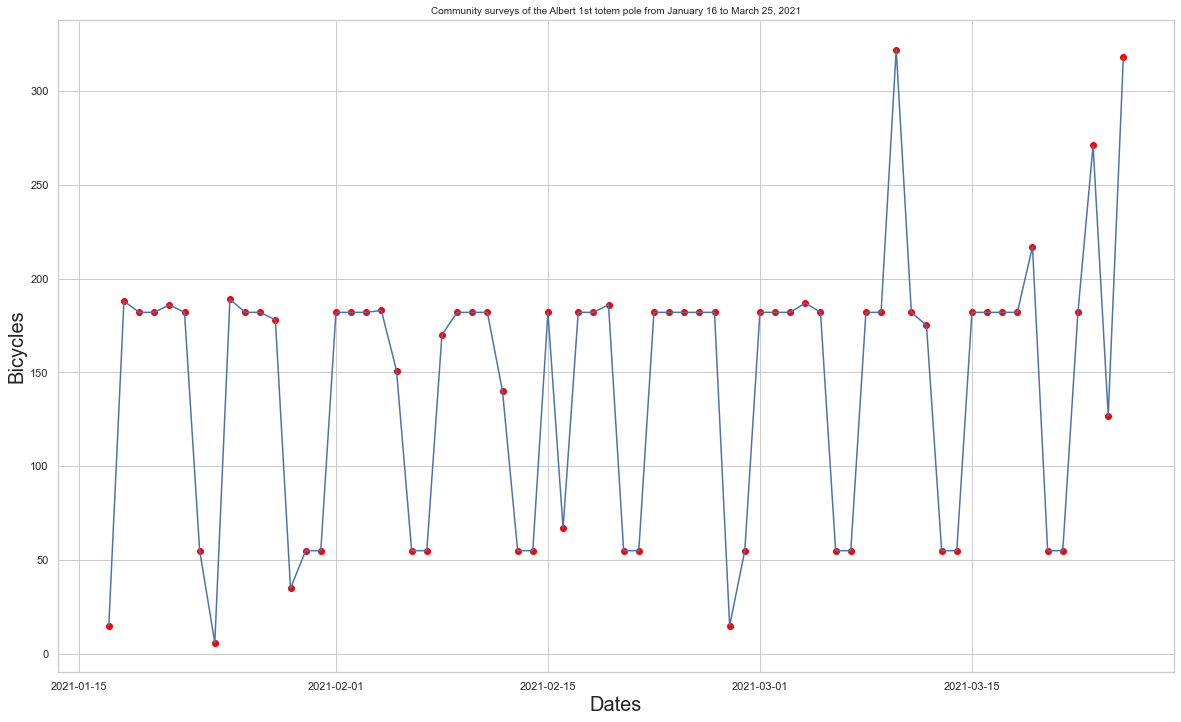

In [25]:

plt.figure(figsize=(20,12))
plt.plot(serie_bike)
plt.scatter(serie_bike.index,serie_bike, color='red')
plt.xlabel('Dates', size=20)
plt.ylabel('Bicycles', size=20)
graph = plt.title('Community surveys of the Albert 1st totem pole from January 16 to March 25, 2021')
graph.set_fontsize(10)

plt.savefig("data.png")

## Creating a commonly used method for time-series, SARIMA

### parameters set

In [12]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
ses = [(x[0], x[1], x[2], 7) for x in pdq]

In [13]:
for param in pdq:
    for ses_param in ses:
        mod1 = sm.tsa.statespace.SARIMAX(serie_bike,order=param,seasonal_order=ses_param,enforce_stationarity=False, enforce_invertibility=False)
        results = mod1.fit()
    print(f'AIC:{results.aic}')
print("Done")

AIC:554.0553941244392
AIC:541.9657543636935
AIC:581.3495187814447
AIC:532.3916309807969
AIC:550.1154020286345
AIC:542.4501444393755
AIC:552.1790716708592
AIC:527.6719397591283
Done


### Predicting observed values

In [14]:
pred = results.get_prediction(start=1, dynamic=False)
pred_conf_int = pred.conf_int()

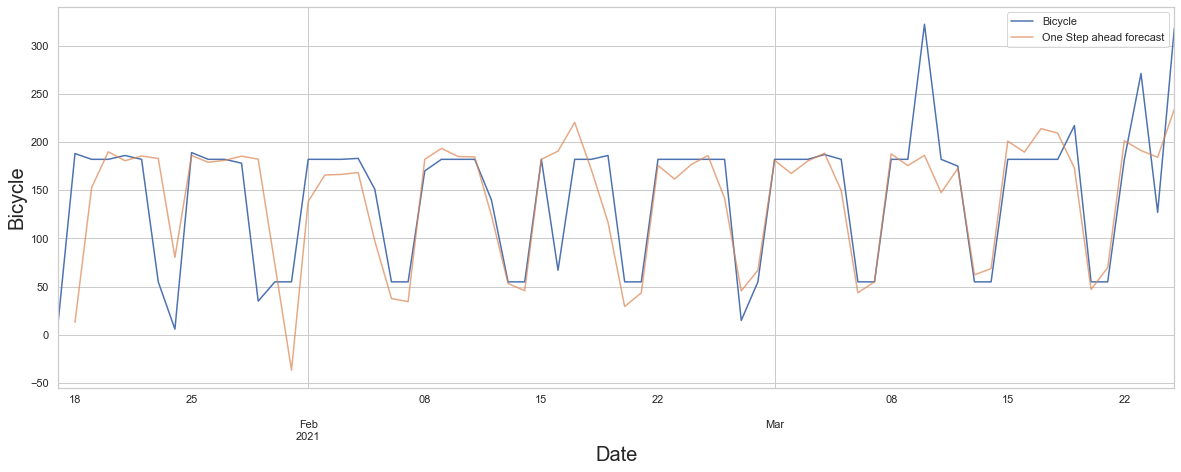

In [15]:
ax = serie_bike.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One Step ahead forecast', alpha=.7, figsize=(20, 7))
#ax.fill_between(pred_conf_int.index,
#                pred_conf_int.iloc[:, 0],
#                pred_conf_int.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date', size=20)
ax.set_ylabel('Bicycle',size=20)
plt.legend()

### Forecasting

In [16]:
predict = results.get_forecast(steps=25)
predict_conf_int = predict.conf_int()

In [17]:
predict.predicted_mean.head()

2021-03-26    135.166064
2021-03-27     88.670926
2021-03-28     63.650127
2021-03-29    205.489500
2021-03-30    199.344666
Freq: D, Name: predicted_mean, dtype: float64

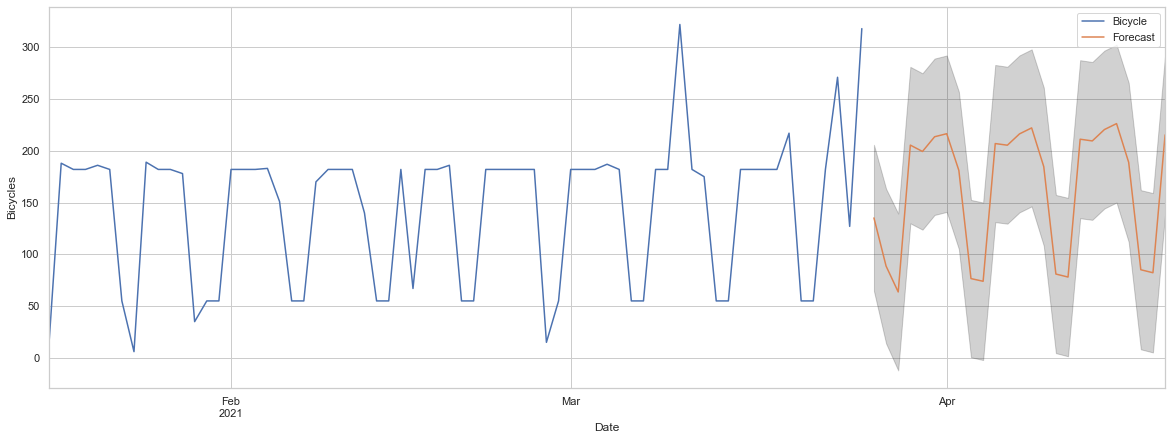

In [18]:
ax = serie_bike.plot(label='observed', figsize=(20, 7))
predict.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(predict_conf_int.index,
                predict_conf_int.iloc[:, 0],
                predict_conf_int.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Bicycles')
plt.legend()
plt.show()

Text(0, 0.5, 'Bicycles')

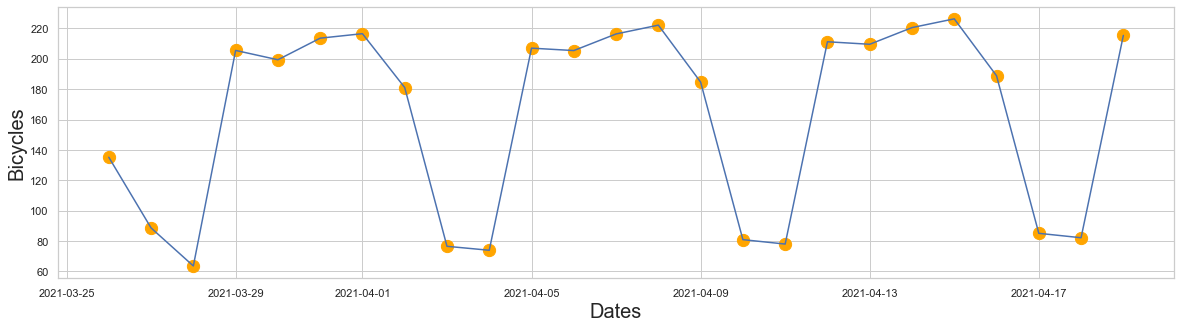

In [19]:
plt.figure(figsize=(20,5))
plt.plot(predict.predicted_mean)
plt.scatter(predict.predicted_mean.index, predict.predicted_mean.values, color="orange", s=150)
plt.xlabel("Dates", size=20)
plt.ylabel("Bicycles", size=20)

## Bicycles passing between 00:01 - 09:00 on April 2, 2021

In [20]:
april_2_9AM = predict.predicted_mean['2021-04-02']

In [21]:
print(f"Predicted number: {round(april_2_9AM)}")

Predicted number: 181
